In [ ]:
# === Plot YOLOv8 training vs validation loss from results.csv ===
# Works for Ultralytics detect/classify/segment results. If there's no single "loss" column,
# it will sum the available *_loss components (e.g., box_loss, cls_loss, dfl_loss).

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- 1) Point this to your results.csv ---
csv_path = Path("/Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8_cbam_backbone/results.csv")

# --- 2) Load CSV ---
df = pd.read_csv(csv_path)

# --- 3) Determine epoch axis (Ultralytics usually has an 'epoch' column) ---
if "epoch" in df.columns:
    x = df["epoch"]
    x_label = "Epoch"
else:
    x = range(len(df))
    x_label = "Epoch (index)"

# --- 4) Find loss columns ---
# Prefer single aggregate if present
train_loss_series = None
val_loss_series = None

if "train/loss" in df.columns:
    train_loss_series = df["train/loss"]
if "val/loss" in df.columns:
    val_loss_series = df["val/loss"]

# If aggregate not present, sum *_loss parts
def sum_loss_parts(prefix: str) -> pd.Series | None:
    # e.g., prefix='train/' → picks columns like 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', etc.
    cols = [c for c in df.columns if c.startswith(prefix) and c.endswith("_loss")]
    if cols:
        return df[cols].sum(axis=1)
    return None

if train_loss_series is None:
    train_loss_series = sum_loss_parts("train/")
if val_loss_series is None:
    val_loss_series = sum_loss_parts("val/")

# Fallback warning if still missing
if train_loss_series is None or val_loss_series is None:
    missing = []
    if train_loss_series is None: missing.append("training loss")
    if val_loss_series is None: missing.append("validation loss")
    raise ValueError(f"Could not infer {', '.join(missing)} from columns: {list(df.columns)}")

# --- 5) Optional smoothing (uncomment to apply a light rolling mean) ---
# window = 5
# train_loss_plot = train_loss_series.rolling(window, min_periods=1, center=False).mean()
# val_loss_plot   = val_loss_series.rolling(window, min_periods=1, center=False).mean()

train_loss_plot = train_loss_series
val_loss_plot   = val_loss_series

# --- 6) Plot ---
plt.figure(figsize=(10, 6))
plt.plot(x, train_loss_plot, label="Training Loss", linewidth=2)
plt.plot(x, val_loss_plot,   label="Validation Loss", linewidth=2)
plt.xlabel(x_label)
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# --- 7) Export (PNG + PDF) next to results.csv ---
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
out_png = csv_path.parent / f"loss_curves_{stamp}.png"
out_pdf = csv_path.parent / f"loss_curves_{stamp}.pdf"
plt.tight_layout()
plt.savefig(out_png, dpi=200)
plt.savefig(out_pdf)
plt.show()

print(f"Saved:\n- {out_png}\n- {out_pdf}")

: 

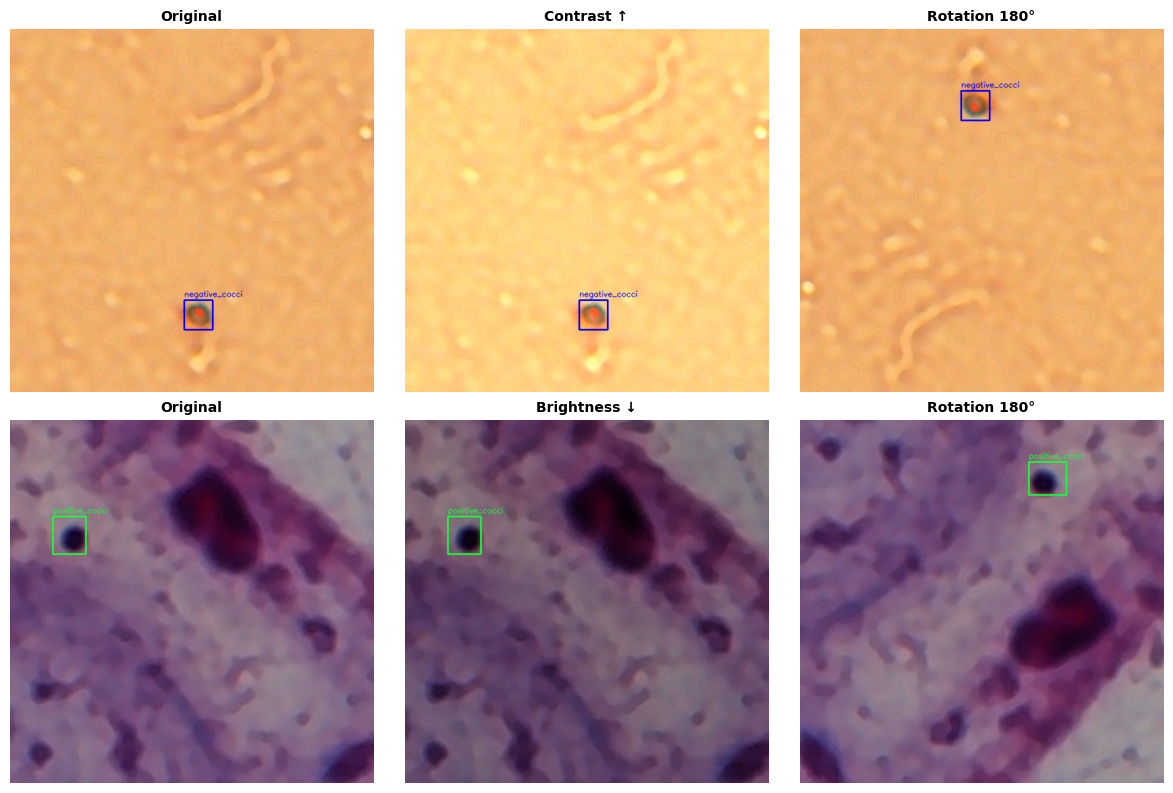

In [5]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# ==== Paths ====
images = [
    # Row 1: same sample (original + augmentations)
    "/Users/karyna/Documents/Alternative TA/Final/images/train/000024_5_2.jpg",
    "/Users/karyna/Documents/Alternative TA/Final/images/train/000024_5_2_aug_00353_contrast_up.jpg",
    "/Users/karyna/Documents/Alternative TA/Final/images/train/000024_5_2_aug_00318_rotate_180.jpg",

    # Row 2: another sample (original + augmentations)
    "/Users/karyna/Documents/Alternative TA/Final/images/train/902037.jpg",
    "/Users/karyna/Documents/Alternative TA/Final/images/train/902037_aug_00713_brightness_down.jpg",
    "/Users/karyna/Documents/Alternative TA/Final/images/train/902037_aug_00354_rotate_90.jpg",
]

LABEL_DIR = Path("/Users/karyna/Documents/Alternative TA/Final/labels/train")
CLASS_NAMES = ["negative_cocci", "positive_cocci", "negative_bacilli", "positive_bacilli"]

# ==== Custom colors (BGR) ====
CLASS_COLORS = {
    0: (255, 0, 0),       # negative_cocci → blue
    1: (57, 255, 20),     # positive_cocci → neon green
    2: (0, 0, 255),       # negative_bacilli → red
    3: (255, 191, 0),     # positive_bacilli → neon blue (cyan-like)
}

def get_label_path(img_path: Path):
    """Return corresponding YOLO label path."""
    return LABEL_DIR / img_path.with_suffix('.txt').name

def draw_yolo_boxes(image_path: Path):
    """Draw YOLOv8-format bounding boxes with class-specific colors."""
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(image_path)
    h, w = img.shape[:2]

    label_path = get_label_path(image_path)
    if not label_path.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, bw, bh = map(float, parts)
            cls = int(cls)
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)

            color = CLASS_COLORS.get(cls, (255, 255, 255))
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, CLASS_NAMES[cls], (x1, y1 - 6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ==== Plot 2×3 grid ====
plt.figure(figsize=(12, 8))
titles = [
    "Original", "Contrast ↑", "Rotation 180°",
    "Original", "Brightness ↓", "Rotation 180°"
]

for i, img_path in enumerate(images):
    ax = plt.subplot(2, 3, i + 1)
    img = draw_yolo_boxes(Path(img_path))
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=10, weight="bold")
    ax.axis("off")

plt.tight_layout()
plt.show()

# To save:
# plt.savefig("/Users/karyna/Documents/Alternative TA/Final/Figures/Figure5_Augmentation_Qualitative.png", dpi=300, bbox_inches='tight')

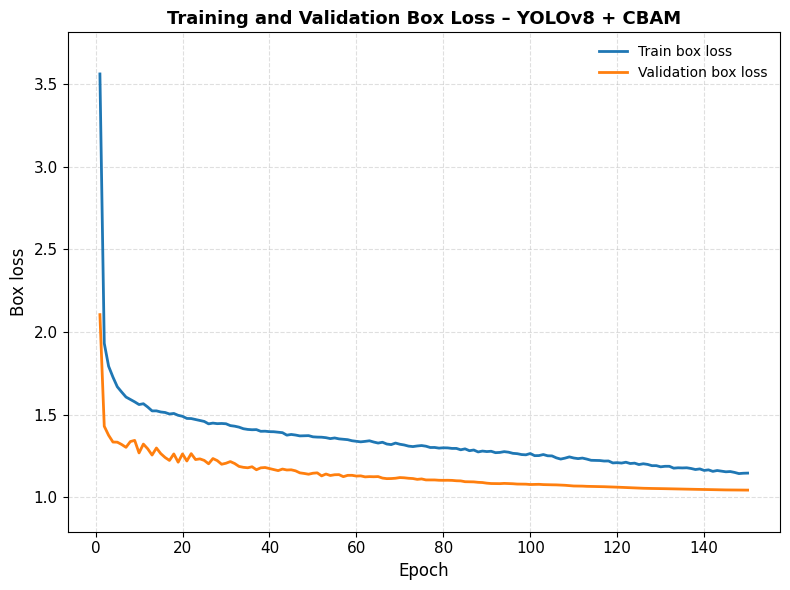

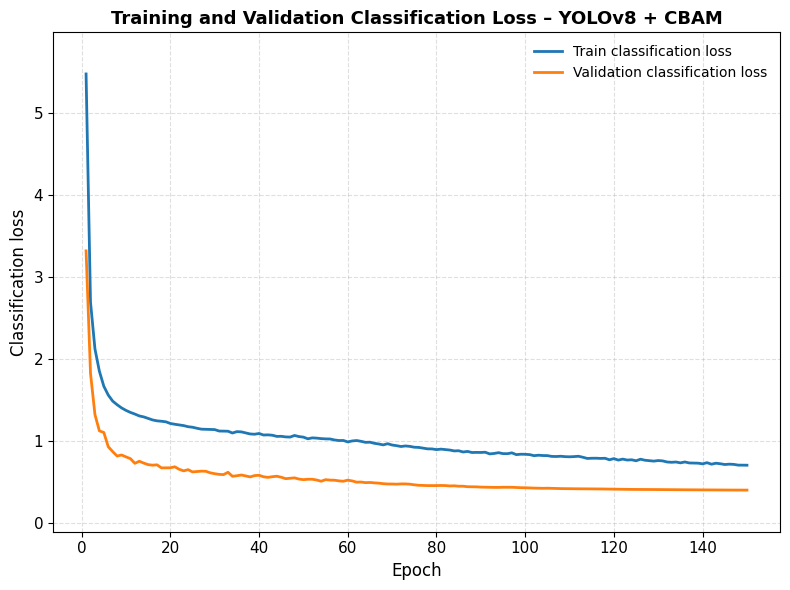

✅ Saved visually balanced (square) plots:
- yolov8_cbam_box_loss.(png/pdf)
- yolov8_cbam_cls_loss.(png/pdf)


In [18]:
# === YOLOv8+CBAM: Export Box Loss and Classification Loss Separately (Square Style) ===
# Output: yolov8_cbam_box_loss.(png/pdf), yolov8_cbam_cls_loss.(png/pdf)

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path("/Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8_cbam_backbone/results.csv")

# --- 1) Load CSV (handle comma/semicolon) ---
try:
    df = pd.read_csv(CSV_PATH)
except Exception:
    df = pd.read_csv(CSV_PATH, sep=";")

# --- 2) Helper to find columns robustly ---
def find_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

epoch_col = "epoch" if "epoch" in df.columns else None
if epoch_col is None:
    df = df.copy()
    df["epoch"] = range(len(df))
    epoch_col = "epoch"

train_box = find_col(["train/box_loss", "box_loss_train", "train_box_loss", "box_loss"])
val_box   = find_col(["val/box_loss",   "box_loss_val",   "val_box_loss"])
train_cls = find_col(["train/cls_loss", "cls_loss_train", "train_cls_loss", "cls_loss"])
val_cls   = find_col(["val/cls_loss",   "cls_loss_val",   "val_cls_loss"])

# --- 3) Common style settings ---
plt.rcParams.update({
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# --- 4) Plot BOX LOSS (square-like) ---
plt.figure(figsize=(8, 6))  # ← square aspect ratio
plt.plot(df[epoch_col], df[train_box], label="Train box loss", linewidth=2)
plt.plot(df[epoch_col], df[val_box],   label="Validation box loss", linewidth=2)
plt.title("Training and Validation Box Loss – YOLOv8 + CBAM", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Box loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best", frameon=False)
plt.margins(y=0.1)  # adds 10% headroom vertically
plt.tight_layout()
plt.savefig(CSV_PATH.with_name("yolov8_cbam_box_loss.png"), dpi=300)
plt.savefig(CSV_PATH.with_name("yolov8_cbam_box_loss.pdf"))
plt.show()

# --- 5) Plot CLASSIFICATION LOSS (square-like) ---
plt.figure(figsize=(8, 6))
plt.plot(df[epoch_col], df[train_cls], label="Train classification loss", linewidth=2)
plt.plot(df[epoch_col], df[val_cls],   label="Validation classification loss", linewidth=2)
plt.title("Training and Validation Classification Loss – YOLOv8 + CBAM", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Classification loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best", frameon=False)
plt.margins(y=0.1)
plt.tight_layout()
plt.savefig(CSV_PATH.with_name("yolov8_cbam_cls_loss.png"), dpi=300)
plt.savefig(CSV_PATH.with_name("yolov8_cbam_cls_loss.pdf"))
plt.show()

print("✅ Saved visually balanced (square) plots:\n- yolov8_cbam_box_loss.(png/pdf)\n- yolov8_cbam_cls_loss.(png/pdf)")


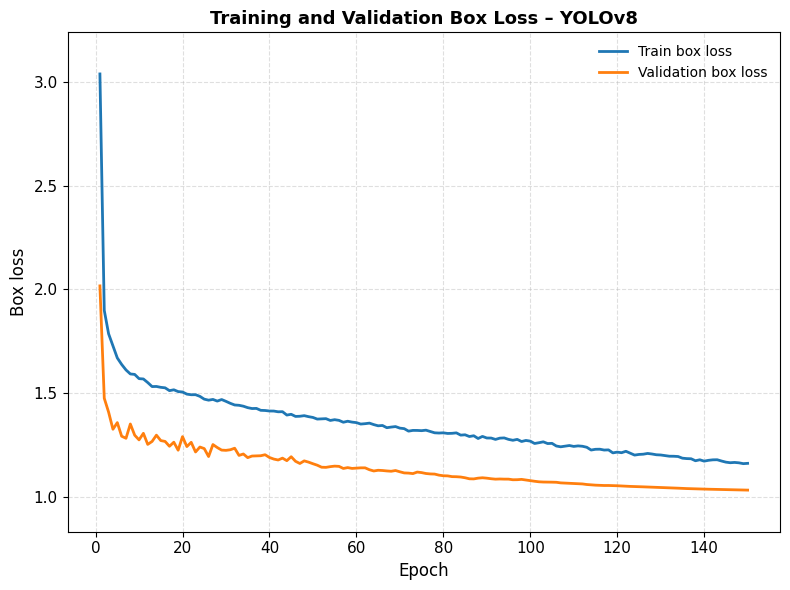

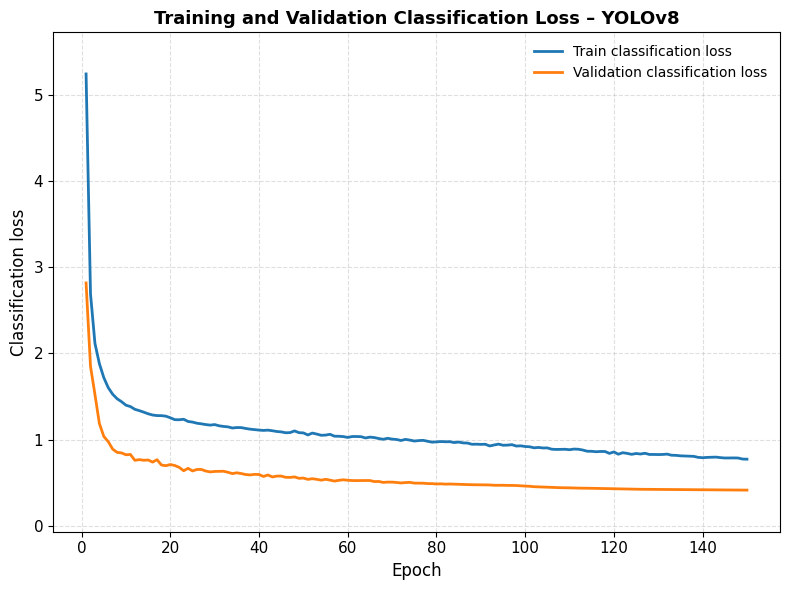

✅ Saved visually balanced (square) plots:
- yolov8_cbam_box_loss.(png/pdf)
- yolov8_cbam_cls_loss.(png/pdf)


In [19]:
# === YOLOv8+CBAM: Export Box Loss and Classification Loss Separately (Square Style) ===
# Output: yolov8_cbam_box_loss.(png/pdf), yolov8_cbam_cls_loss.(png/pdf)

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path("/Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8/results.csv")

# --- 1) Load CSV (handle comma/semicolon) ---
try:
    df = pd.read_csv(CSV_PATH)
except Exception:
    df = pd.read_csv(CSV_PATH, sep=";")

# --- 2) Helper to find columns robustly ---
def find_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

epoch_col = "epoch" if "epoch" in df.columns else None
if epoch_col is None:
    df = df.copy()
    df["epoch"] = range(len(df))
    epoch_col = "epoch"

train_box = find_col(["train/box_loss", "box_loss_train", "train_box_loss", "box_loss"])
val_box   = find_col(["val/box_loss",   "box_loss_val",   "val_box_loss"])
train_cls = find_col(["train/cls_loss", "cls_loss_train", "train_cls_loss", "cls_loss"])
val_cls   = find_col(["val/cls_loss",   "cls_loss_val",   "val_cls_loss"])

# --- 3) Common style settings ---
plt.rcParams.update({
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# --- 4) Plot BOX LOSS (square-like) ---
plt.figure(figsize=(8, 6))  # ← square aspect ratio
plt.plot(df[epoch_col], df[train_box], label="Train box loss", linewidth=2)
plt.plot(df[epoch_col], df[val_box],   label="Validation box loss", linewidth=2)
plt.title("Training and Validation Box Loss – YOLOv8", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Box loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best", frameon=False)
plt.margins(y=0.1)  # adds 10% headroom vertically
plt.tight_layout()
plt.savefig(CSV_PATH.with_name("yolov8_cbam_box_loss.png"), dpi=300)
plt.savefig(CSV_PATH.with_name("yolov8_cbam_box_loss.pdf"))
plt.show()

# --- 5) Plot CLASSIFICATION LOSS (square-like) ---
plt.figure(figsize=(8, 6))
plt.plot(df[epoch_col], df[train_cls], label="Train classification loss", linewidth=2)
plt.plot(df[epoch_col], df[val_cls],   label="Validation classification loss", linewidth=2)
plt.title("Training and Validation Classification Loss – YOLOv8", weight="bold")
plt.xlabel("Epoch")
plt.ylabel("Classification loss")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="best", frameon=False)
plt.margins(y=0.1)
plt.tight_layout()
plt.savefig(CSV_PATH.with_name("yolov8_cbam_cls_loss.png"), dpi=300)
plt.savefig(CSV_PATH.with_name("yolov8_cbam_cls_loss.pdf"))
plt.show()

print("✅ Saved visually balanced (square) plots:\n- yolov8_cbam_box_loss.(png/pdf)\n- yolov8_cbam_cls_loss.(png/pdf)")

In [10]:
import pandas as pd
df = pd.read_csv("/Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8/results.csv")
df_small = df[["epoch","train/box_loss","val/box_loss","train/cls_loss","val/cls_loss"]]
df_small.head(30).to_csv("yolov8_loss_sample.csv", index=False)

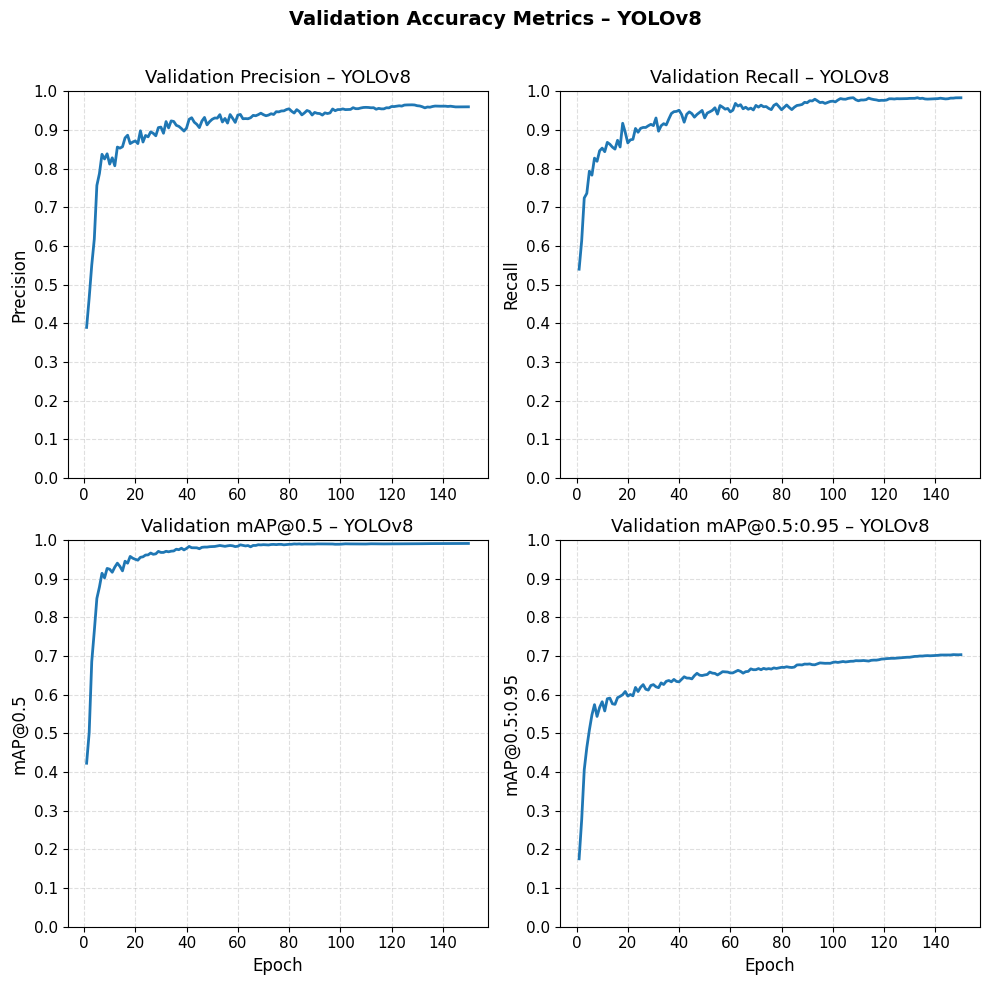

Saved:
- /Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8/yolov8_val_pr_map_0to1.png
- /Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8/yolov8_val_pr_map_0to1.pdf


In [24]:
# === 2×2 Composite: Val Precision, Recall, mAP@0.5, mAP@0.5:0.95 (Y-axis fixed to [0,1]) ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH  = Path("/Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8/results.csv")  # change per model
MODEL_TAG = "YOLOv8"  # or "YOLOv8 + CBAM"

# -- load
try:
    df = pd.read_csv(CSV_PATH)
except Exception:
    df = pd.read_csv(CSV_PATH, sep=";")

def find_col(cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

epoch = "epoch" if "epoch" in df.columns else None
if epoch is None:
    df = df.copy()
    df["epoch"] = range(len(df))
    epoch = "epoch"

# -- resolve columns (common Ultralytics variants)
val_precision = find_col(["metrics/precision(B)", "metrics/precision", "val/precision", "precision", "Precision"])
val_recall    = find_col(["metrics/recall(B)",    "metrics/recall",    "val/recall",    "recall",    "Recall"])
val_map50     = find_col(["metrics/mAP50(B)",     "metrics/mAP_0.5",   "metrics/mAP50", "val/mAP50", "mAP50"])
val_map5095   = find_col(["metrics/mAP50-95(B)",  "metrics/mAP",       "metrics/mAP50-95",
                          "val/mAP50-95", "mAP50-95", "mAP@0.5:0.95"])

missing = [name for name, col in {
    "val_precision": val_precision,
    "val_recall":    val_recall,
    "val_map50":     val_map50,
    "val_map50:95":  val_map5095
}.items() if col is None]
if missing:
    raise KeyError(f"Missing columns: {missing}\nAvailable: {list(df.columns)}")

# -- style
plt.rcParams.update({"axes.labelsize": 12, "axes.titlesize": 13, "xtick.labelsize": 11, "ytick.labelsize": 11})

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
(ax1, ax2), (ax3, ax4) = axes

def lock01(ax, ylab):
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_ylabel(ylab)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.margins(y=0)  # no extra padding; exact 0..1

# Precision
ax1.plot(df[epoch], df[val_precision], lw=2)
ax1.set_title(f"Validation Precision – {MODEL_TAG}")
lock01(ax1, "Precision")

# Recall
ax2.plot(df[epoch], df[val_recall], lw=2)
ax2.set_title(f"Validation Recall – {MODEL_TAG}")
lock01(ax2, "Recall")

# mAP@0.5
ax3.plot(df[epoch], df[val_map50], lw=2)
ax3.set_title(f"Validation mAP@0.5 – {MODEL_TAG}")
lock01(ax3, "mAP@0.5")
ax3.set_xlabel("Epoch")

# mAP@0.5:0.95
ax4.plot(df[epoch], df[val_map5095], lw=2)
ax4.set_title(f"Validation mAP@0.5:0.95 – {MODEL_TAG}")
lock01(ax4, "mAP@0.5:0.95")
ax4.set_xlabel("Epoch")

fig.suptitle(f"Validation Accuracy Metrics – {MODEL_TAG}", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])

out_png = CSV_PATH.with_name(f"{MODEL_TAG.lower().replace(' ', '_')}_val_pr_map_0to1.png")
out_pdf = CSV_PATH.with_name(f"{MODEL_TAG.lower().replace(' ', '_')}_val_pr_map_0to1.pdf")
plt.savefig(out_png, dpi=300)
plt.savefig(out_pdf)
plt.show()

print(f"Saved:\n- {out_png}\n- {out_pdf}")


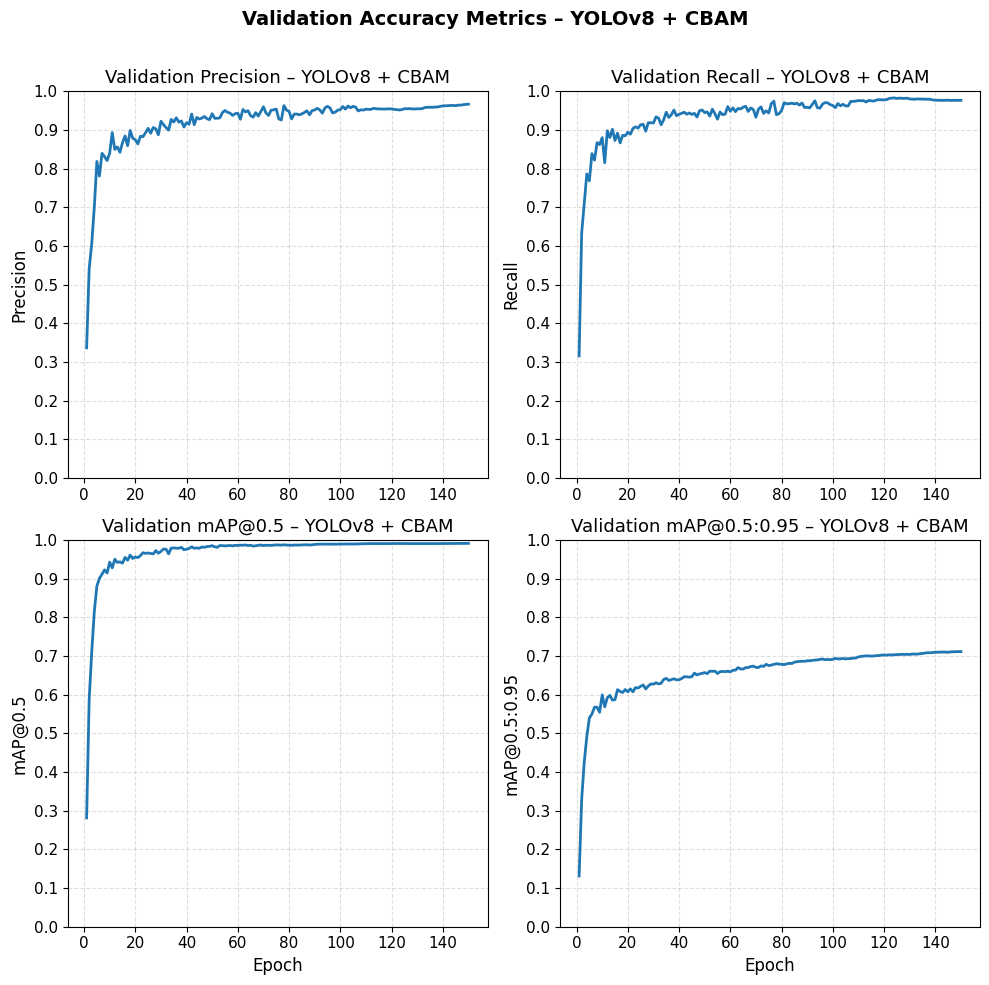

Saved:
- /Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8_cbam_backbone/yolov8_+_cbam_val_pr_map_0to1.png
- /Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8_cbam_backbone/yolov8_+_cbam_val_pr_map_0to1.pdf


In [25]:
# === 2×2 Composite: Val Precision, Recall, mAP@0.5, mAP@0.5:0.95 (Y-axis fixed to [0,1]) ===
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH  = Path("/Users/karyna/Documents/Alternative TA/Final/runs/detect/yolov8_cbam_backbone/results.csv")  # change per model
MODEL_TAG = "YOLOv8 + CBAM"  # or "YOLOv8 + CBAM"

# -- load
try:
    df = pd.read_csv(CSV_PATH)
except Exception:
    df = pd.read_csv(CSV_PATH, sep=";")

def find_col(cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

epoch = "epoch" if "epoch" in df.columns else None
if epoch is None:
    df = df.copy()
    df["epoch"] = range(len(df))
    epoch = "epoch"

# -- resolve columns (common Ultralytics variants)
val_precision = find_col(["metrics/precision(B)", "metrics/precision", "val/precision", "precision", "Precision"])
val_recall    = find_col(["metrics/recall(B)",    "metrics/recall",    "val/recall",    "recall",    "Recall"])
val_map50     = find_col(["metrics/mAP50(B)",     "metrics/mAP_0.5",   "metrics/mAP50", "val/mAP50", "mAP50"])
val_map5095   = find_col(["metrics/mAP50-95(B)",  "metrics/mAP",       "metrics/mAP50-95",
                          "val/mAP50-95", "mAP50-95", "mAP@0.5:0.95"])

missing = [name for name, col in {
    "val_precision": val_precision,
    "val_recall":    val_recall,
    "val_map50":     val_map50,
    "val_map50:95":  val_map5095
}.items() if col is None]
if missing:
    raise KeyError(f"Missing columns: {missing}\nAvailable: {list(df.columns)}")

# -- style
plt.rcParams.update({"axes.labelsize": 12, "axes.titlesize": 13, "xtick.labelsize": 11, "ytick.labelsize": 11})

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
(ax1, ax2), (ax3, ax4) = axes

def lock01(ax, ylab):
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(0, 11)])
    ax.set_ylabel(ylab)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.margins(y=0)  # no extra padding; exact 0..1

# Precision
ax1.plot(df[epoch], df[val_precision], lw=2)
ax1.set_title(f"Validation Precision – {MODEL_TAG}")
lock01(ax1, "Precision")

# Recall
ax2.plot(df[epoch], df[val_recall], lw=2)
ax2.set_title(f"Validation Recall – {MODEL_TAG}")
lock01(ax2, "Recall")

# mAP@0.5
ax3.plot(df[epoch], df[val_map50], lw=2)
ax3.set_title(f"Validation mAP@0.5 – {MODEL_TAG}")
lock01(ax3, "mAP@0.5")
ax3.set_xlabel("Epoch")

# mAP@0.5:0.95
ax4.plot(df[epoch], df[val_map5095], lw=2)
ax4.set_title(f"Validation mAP@0.5:0.95 – {MODEL_TAG}")
lock01(ax4, "mAP@0.5:0.95")
ax4.set_xlabel("Epoch")

fig.suptitle(f"Validation Accuracy Metrics – {MODEL_TAG}", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])

out_png = CSV_PATH.with_name(f"{MODEL_TAG.lower().replace(' ', '_')}_val_pr_map_0to1.png")
out_pdf = CSV_PATH.with_name(f"{MODEL_TAG.lower().replace(' ', '_')}_val_pr_map_0to1.pdf")
plt.savefig(out_png, dpi=300)
plt.savefig(out_pdf)
plt.show()

print(f"Saved:\n- {out_png}\n- {out_pdf}")
